# Getting Started with pySmash

*pysmash: A Python Package for the Mine of Significant Fragments from Specific Dataset*

<img align="left" src="./image/pysmash.png" width="100" style="margin-bottom:-3px">

This document intends to provide users with the basic operation methods of pySmash. If you find any mistake or have suggestions for improvements, please either fix them in the source document (the .py file) or send to the mailing list: oriental-cds@163.com and kotori@cbdd.me.

## Installing the pySmash package

### Dependencies

```
rdkit=="2019.03.1"
pandas
numpy
```
**Notice:** More least version of RDKit may throw an unexpection.

### Install with source

```
git clone git@github.com:kotori-y/pySmash.git && cd scopy
[sudo] python setup.py install
```

## Overview

In the field of chemoinformatics, there is a saying that similar structures have similar properties. The main aim of chemoinformatics refers to analyzing the similarity among molecules, searching the molecules in the structural database, finding potential drug molecule and their property. To systematically obtain the relation between structure and property, we developed pySmash, a Python library designed for obtaining fragments, which are highly related to a specific endpoint conveniently and comprehensively. pySmash can smash molecules, which have certein property label, with three different algorithms, including **circular**-, **path**- and **function group**-based, and combined with statistical methods to a set of significant fragments. By using these fragments, the molecule with unknown label can got a predicted label. Besides, pySmash provides functionalities for the easy visualization of the derived fragments. The Python package pySmash is designed by [CBDD Group](http://home.scbdd.com/index.php?s=/Home/Index.html&t=english
) (Computational Biology & Drug Design Group), Xiangya School of Pharmaceutical Sciences, Central South University.

pySmash provides 3 algorithms, including circular-, path-, and function group-based, to smash a molecule.

(1) Circular-based fragment
Circular fragments is built by applying the Morgan algorithm. When generating circular fragments, Morgan fingerprints are calculated firstly under the given radius, and then circular fragments would be retrieved through combining the information of each bit with specific function.

(2) Path-based fragment
The path-based fragment algorithm identifies all subgraphs in the molecule within a particular range of sizes. Like generation of circular fragments, the RDKit fingerprints are calculated at first under minimum and maximum length. Through the bitinfo, the fragments are obtained.

(3) Function Group-based fragment
This fragments are implemented by this article, which proposed an algorithm to identify functional groups in organic molecules.



The statistical method to judge a fragment is significant based on the probability density function of the binomial distribution with following equation:<br>
$$P_{value}=\Sigma_{i=ms}^{ns}\frac{ns!}{i!(ns-i)!}(\frac{m}{n})^{i}(1-\frac{m}{n})^{ns-i}$$

**Note:** In $n$ compounds has $m$ compounds with aspecific activity label and specific fragment is found in $ns$ compounds the amount of those compounds with the specific activity label is $ms$.

## Implementation

The pySmash is mainly based on the RDKit implementation of circular Morgan fingerprints, RDKit fingerprints and functional group in contri of RDKit. The library is divided in 2 modules:

(1) Base *Class* and *Function* in <code>fragments</code> to calculate fragments and obtain fragments matrix;

(2) The encapsulate in <code>\_\_init\_\_.py</code> to dispose fragments under given condition to obtain significant fragments.

While generating significant fragments related with specific property (e.g. toxicity), a set of molecules with a corresponding label would be necessary. Next, we will take the circular fragment generation as an example to show how pySmash works.

(1) Firstly, **pySmash** will compute hashed or unhashed Morgan fingerprints of each molecule, and then return the information of positive bit, which defined as a dictionary whose each key corresponds to a unique substructure. The bitinfo not only contains the ID of center atom but also the radius of the fragment;

(2) Through taking the union of the key of all substructures presence in each molecule, a binary matrix can be generated. It is worth noting that, for each molecule, through the radius of substructure, we can selectively output only the largest structure in each center atom for matrix generation;

(3) Lastly, **pySmash** dispose the previous matrix under some preset parameters and statistical methods, then return the matrix of significant fragments and their related statistical information;

(4) The output mainly contains a fitted model object which can be used to predict non-label molecules.

<center>
<img src="image/flow.png" style="margin-bottom:-3px" width="700" align="left">
<br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">The work flow of pySmash</div>
</center>

## pySmash Tutorial

This tutorial will take **ISSCAN** database on chemical carcinogens with **jupyter** environment as an example  to show how to use **pySmash** package.

In [42]:
#rdkit modules
from rdkit import Chem

# science modules
import pandas as pd
import numpy as np

#Display
import IPython
from rdkit.Chem.Draw import IPythonConsole

In [2]:
data = pd.read_csv('./datasets/Carc/Carc.txt', sep='\t') # loading data
pd.set_option('display.max_rows', 10)
data

,SMILES,Label
0,CN(c1ccc(cc1)N=Nc1ccccc1)C,1
1,CC(=O)Nc1cccc2c1c1ccccc1C2,0
2,c1cc2ccc3c4c2c(c1)ccc4ccc3,0
3,ClC(Cl)Cl,1
4,CC/C(=C(\c1ccc(cc1)O)/CC)/c1ccc(cc1)O,1
...,...,...
1111,OC(=O)C1=NN(C(=O)C1/N=N/c1ccc(cc1)S(=O)(=O)O)c1ccc(cc1)S(=O)(=O)O,1
1112,CN1C2CCC1CC(C2)NC(=O)c1cc(Cl)cc2c1OC(C2)(C)C,0
1113,O=C1C=CC(=O)C=C1,1
1114,c1ccc2c(c1)sc(n2)SSc1nc2c(s1)cccc2,0


The filed Label 1 = carcinogen(i.e. positive) and 0 = noncarcinogen(i.e. negative)

In [26]:
mols = [Chem.MolFromSmiles(smi) for smi in data.SMILES.values]
labels = data.Label.values

### Generating Fragments for single molecule

The function <code>GetCircularFragment()</code>, <code>GetPathFragment()</code> and <code>GetFunctionGroupFragment()</code> from <code>smash.fragments</code> can smash a molecule to several fragments based on different algorithms.

In [9]:
from smash.fragments import GetCircularFragment, GetPathFragment, GetFunctionGroupFragment

#### Circular Fragment

The <code>GetCircularFragment()</code> can be used to generate the circular fragment, and could accept eight parameters:

    mol : rdkit.Chem.rdchem.Mol object
        Compound to be Calculated
    minRadius : int, optional
        The probable minimum radius of circular fragment, by default 1
    maxRadius : int, optional
        The probable maximum radius of circular fragment, by default 2
    nBits : int, optional
        the number of bit of morgan, by default 1014
        this param would be ignored, if the folded set as False.
    folded : bool, optional
        which generate fragment based on unfolded fingerprint, by default True.
    maxFragment : bool, optional
        Whether only return the maximum fragment at a center atom, by default True
    nJobs : int, optional
        The number of CPUs to use to do the computation, by default 1
    svg : bool, optional
        Whether output with a svg image, by default False

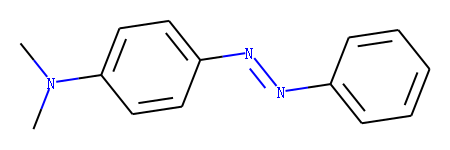

In [7]:
mol = Chem.MolFromSmiles(data.SMILES.values[0])
mol

In [11]:
cirFrag = GetCircularFragment(mol, minRadius=1, maxRadius=4,
                              folded=False, maxFragment=True)
cirFrag

([98513984,
  166544320,
  601301716,
  742000539,
  817010262,
  847336149,
  848128881,
  867943757,
  951226070,
  1052483895,
  1070736864,
  1166893553,
  1279318804,
  1421848111,
  1423313569,
  1449131080,
  1914416804,
  2094236579,
  2138432469,
  2206467902,
  2234413793,
  2246728737,
  2393963875,
  2538220925,
  2763854213,
  2891101840,
  3021462385,
  3097783358,
  3217380708,
  3218693969,
  3707826210,
  3801174218,
  3816821150,
  3818546315,
  3999906991,
  4085189049],
 {3818546315: ('*N(*)C',),
  2393963875: ('*cc(c*)N(C)C',),
  3707826210: ('*c1ccc(N(C)C)cc1',),
  1423313569: ('*N=Nc1ccc(N(C)C)cc1',),
  3816821150: ('*c(*)N=Nc1ccc(N(C)C)cc1',),
  3021462385: ('*N(*)c1ccc(N=Nc(c*)c*)cc1',),
  3801174218: ('*c1*cc(N=*)cc1',),
  166544320: ('*c1*cc(N(*)*)cc1',),
  2138432469: ('*c1ccc(N=Nc2cc*cc2)cc1',),
  867943757: ('*1ccc(N=Nc2ccccc2)cc1',),
  4085189049: ('*cc(c*)N=Nc1ccccc1',),
  1166893553: ('*N=Nc1ccccc1',),
  1279318804: ('*=Nc1ccccc1',),
  742000539: ('*c1c

The function return a <code>tuple</code>. The first element is the ID of **all** fragments generated, and the second one is a <code>dict</code> whose key is the ID of outputted fragments, value is corresponding SMARTS and svg string (if <code>svg</code> set as True).

#### Path Fragment

The <code>GetPathFragment()</code> can be used to generate the path-based fragment, and could accept seven parameters:

    mol : dkit.Chem.rdchem.Mol object
        Compound to be Calculated
    minPath : int, optional
        The probable minimum length of path-based fragment, by default 1
    maxPath : int, optional
        The probable maximum length of path-based fragment, by default 7
    nBits : int, optional
        the number of bit of morgan, by default 1014
        this param would be ignored, if the folded set as False.
    folded : bool, optional
        which generate fragment based on unfolded fingerprint, by default True.
    maxFragment : bool, optional
        Whether only return the maximum fragment at a center atom, by default True
    svg : bool, optional
        Whether output with a svg image, by default False

In [13]:
pathFrag = GetPathFragment(mol, minPath=1, maxPath=7,
                           folded=False, maxFragment=True)
pathFrag

([156235170,
  166056096,
  207980049,
  269062317,
  278485227,
  290216348,
  374073638,
  375489799,
  464351883,
  489366768,
  648366653,
  684254069,
  794080973,
  801668886,
  821756180,
  883786409,
  983288516,
  1019450028,
  1094198543,
  1128172915,
  1149969909,
  1185041240,
  1212154305,
  1231169922,
  1232610214,
  1336954020,
  1341487704,
  1345130172,
  1381895560,
  1469891971,
  1515308438,
  1651041015,
  1721559976,
  1762587153,
  1770364917,
  1795955411,
  1856292486,
  1936313601,
  1949583554,
  2006353631,
  2010367100,
  2041049663,
  2187949147,
  2196711674,
  2281195258,
  2418098212,
  2452710580,
  2476637785,
  2562876123,
  2577170428,
  2650317052,
  2698527641,
  2738554296,
  2855649477,
  2955077156,
  2965878653,
  3100332986,
  3137502397,
  3183416455,
  3190653530,
  3246816004,
  3247793502,
  3274248866,
  3330326592,
  3341727425,
  3494989292,
  3509554884,
  3517902689,
  3752102730,
  3764713633,
  3826517238,
  3984285402,
  4006821

Samely, this function return a <code>tuple</code>. The first element is the ID of **all** fragments generated, and the second one is a <code>dict</code> whose key is the ID of outputted fragments, value is corresponding SMARTS and svg string (if <code>svg</code> set as True).

#### FunctionGroup Fragment

The <code>GetFunctionGroupFragment()</code> can be used to generate the function group fragment, and could accept only one parameters:

    mol : dkit.Chem.rdchem.Mol object
        Compound to be Calculated
    svg : bool, optional
        Whether output with a svg image, by default False

In [15]:
fgFrag = GetFunctionGroupFragment(mol)
fgFrag

[('cN=Nc',), ('cN(C)C',)]

Differently, this function return a <code>tuple</code> of <code>list</code>. In each tuple element, the first element is the SMARTS of fragment and the second one svg string (is svg set as True).

### Generating Fragments Matrix

The Class <code>Circular()</code>, <code>Path()</code> and <code>FunctionGroup()</code> from <code>smash.fragments</code> can generate fragments for a set of molecule and return a fragment matrix.

In [17]:
cir = CircularLearner(minRadius=1, maxRadius=4)
cirMatrix = cir.GetCircularMatrix(mols)
cirMatrix

,3189374977,4057006083,3849781254,1692696596,2996895764,3884023835,1868824604,3123347485,2536964126,3858497572,...,838893522,2822209494,178782170,1992589278,3637149665,1407549416,1068204010,3158114287,1436286969,477790203
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Through calling <code>fragments</code> attribute to obtain the fragment of each molecule

In [21]:
print(type(cir.fragments))
cir.fragments[1]

<class 'list'>


([43357009,
  98513984,
  108636803,
  148111336,
  188636353,
  357479950,
  411967733,
  550940897,
  697834592,
  716321151,
  847961216,
  864942730,
  951226070,
  1020050621,
  1199438732,
  1255595680,
  1323467736,
  1510328189,
  1528858153,
  1651469392,
  1721838581,
  1790668568,
  1822270925,
  1842898132,
  1967842891,
  2246699815,
  2246728737,
  2285694778,
  2395941840,
  2443601519,
  2485791489,
  2893110683,
  2968968094,
  3075161160,
  3172526181,
  3217380708,
  3218693969,
  3245643333,
  3315961971,
  3390623902,
  3455955148,
  3462479532,
  3488480553,
  3545365497,
  3630982498,
  3692055567,
  3935156648,
  3980805843,
  3982076256,
  3999906991,
  4041573576,
  4142616092],
 {3545365497: ('*C(=*)C',),
  43357009: ('*c(*)NC(C)=O',),
  1510328189: ('*C(*)=O',),
  3075161160: ('*c1*ccc(NC(C)=O)c1-c(*)*',),
  3245643333: ('CC(=O)Nc1cccc2c1-c1cc*cc1C2',),
  1967842891: ('*C(=*)Nc1cccc(*)c1-c(*)*',),
  2893110683: ('*C(=*)Nc1cccc2c1-c(*)c(*)C2',),
  357479950: 

By calling the attribute <code>substructure</code>, users can get the mapping table of ID and SMARTS of fragments.

In [23]:
cir.substructure

,SMARTS
3818546315,*N(*)C
2393963875,*cc(c*)N(C)C
3707826210,*c1ccc(N(C)C)cc1
1423313569,*N=Nc1ccc(N(C)C)cc1
3816821150,*c(*)N=Nc1ccc(N(C)C)cc1
...,...
1210522019,*c(*)SSc1nc2ccccc2s1
2539119380,*cc1nc(SSc2nc(*)c(*)s2)sc1c*
2898961219,*N(*)CCN(C)N=O
2472299575,CN(C)CCN(C)N=O


The **Path** and **FuntionGroup** fragment matrix are similar to **Circular** one.

### Obtain significant fragments

The statistical method to judge a fragment is significant based on the probability density function of the binomial distribution with following equation:<br>
$$P_{value}=\Sigma_{i=ms}^{ns}\frac{ns!}{i!(ns-i)!}(\frac{m}{n})^{i}(1-\frac{m}{n})^{ns-i}$$

**Note:** In $n$ compounds has $m$ compounds with aspecific activity label and specific fragment is found in $ns$ compounds the amount of those compounds with the specific activity label is $ms$.

User can dispose the above mentioned fragment matrix with function <code>samsh.Pvalue()</code>. 

In [24]:
from smash import Pvalue

In [28]:
n = len(cirMatrix)
m = labels.sum()
#the 3189374977 fragment 
ns = cirMatrix.iloc[:,0].sum()
ms = cirMatrix.iloc[:,0][labels==1].sum()

In [30]:
sum(Pvalue(n, m, ns, ms))

0.6792114695340502

The $P_{value}$ of *3189374977* is higher than what we generally think of as the threshold of significance: 0.05.Therefore, it is considered that this fragment has no correlation with chemical carcinogens.

Besides calculating the $P_{value}$ of each fragment one by one, we encapsulated three Class: <code>smash.CircularLearner</code>, <code>smash.PathLearner</code> and <code>smash.FunctionGroupLearner</code> to easily obtain the highly correlated fragments.

In [31]:
cirLearner = CircularLearner(minRadius=1, maxRadius=4) #determine the size of the fragment

Through <code>fit</code> method, the learner can summarize the corresponding type of significant fragments.

The <code>fit</code> method could accept eight parameters:

    mols : Iterable object, and each element is a rdkit.Chem.rdchem.Mol object
        Compounds, which have aspecific endpoint label, used to obtain significant fragments
    labels : array-like of shape (len(mols),)
        The target values (class labels in classification)
    aimLabel : any, optional
        The label to be regarded as activity label (class labels in classification), by default 1
    minNum : int, optional
        The minimum frequency a fragment required, by default 5
    pCutoff : float, optional
        The pvalue cutoff, a fragment would be regarded as significant if its pvalue below pCutoff, by default 0.05
    accCutoff : float, optional
        The minimum accraucy lead by a fragment judge, by default None
    Bonferroni : bool, optional
        Whether use Bonferroni method to revised, by default False
    svg : bool, optional
        Whether output with a svg image, by default True

In [33]:
cirLearner.fit(mols, labels, aimLabel=1,
               pCutoff=0.05, accCutoff=0.7)

Similarity, calling <code>sigMatrix</code> attribute, user can obtain the **significant** fragments matrix.

In [34]:
cirLearner.sigMatrix

,2380084179,3153453529,1470580613,3440991424,3356397823,1083852209,1147919419,2378775366,3095540251,2378779377,...,178782170,1330196390,535847852,198706261,1495075844,4235614536,3888780669,3989046787,3575264755,1429883190
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calling the <code>sigPvalue</code> attribute, a statistical information of significant fragments including the $P_{value}$ will be returned.

**Note:**<br>
$Accuracy=\frac{ms}{ns}$ $Coverage=\frac{ms}{m}$

The default highlight colors for the Morgan bits indicate:

    blue: the central atom in the environment

    yellow: aromatic atoms

    gray: aliphatic ring atoms

In [37]:
IPython.display.HTML(cirLearner.sigPvalue.to_html(escape=False))

The *sigPvalue* and *fitted learner* can be saved by calling <code>savePvalue</code> and <code>saveModel</code> respectively. Through the *fitted learner*, user can predict the non-label molecules.

### Predicting with Significant Fragments

Through <code>Predict</code> method, user can predict non-label molecules.

In [40]:
testMols = Chem.SDMolSupplier(r"./datasets/Test/50.sdf")
testMols = [mol for mol in testMols]
predLabel, predMatrix = cirLearner.predict(testMols)

This method return two variable, the first one if the predicted label of input molecules, another one is the predicted fragment matrix. 

In [43]:
predLabel

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])